<a href="https://colab.research.google.com/github/rg-smith/groundwater_hydrology/blob/main/assignment4/assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

****Assignment 4****

***Part 1***



First, read chapter 3 from this textbook: https://gw-project.org/books/analysis-and-evaluation-of-pumping-test-data/ 

Then go through the exercise below

In [1]:
! git clone https://github.com/rg-smith/groundwater_hydrology.git

import numpy as np
from scipy.special import expi
import matplotlib.pyplot as plt
import pandas as pd

Cloning into 'groundwater_hydrology'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 56 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (56/56), done.


Here we define the drawdown function for the Theis assumptions. The screenshot below is from page 62 of a free online text: https://gw-project.org/books/analysis-and-evaluation-of-pumping-test-data/. Here they define KD as transmissivity, but to stay consistent with course material we define it as T.

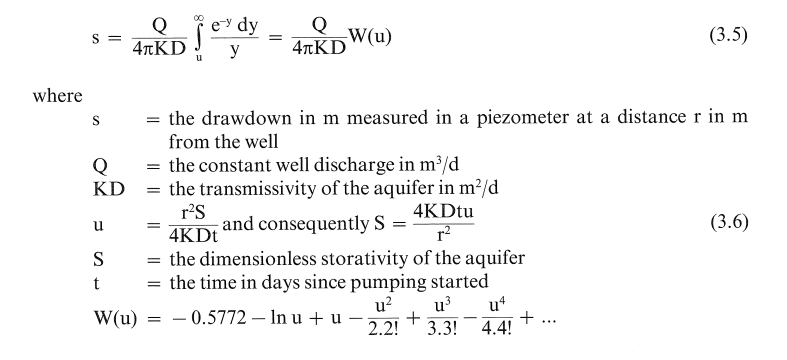

In [2]:
def W(u):  return -expi(-u)

def Theis_drawdown(Q,T,r,S,duration=2):
  t=np.linspace(0,duration,10000)
  u=r**2*S/(4*T*t)
  s=(Q/(4*np.pi*T))*W(u)
  return(t,s)

Assume we have a confined aquifer of thickness 20 m. The aquifer is laterally extensive, and fairly horizontal. Matrix flow is the primary mechanism for groundwater flow (there is little to no fracture-flow). A pump test is conducted in the aquifer when all nearby wells have been turned off for a significant period, so there is little likelihood that influences from other wells would affect temporal variation in head.

Load and plot drawdown data

In [ ]:
drawdown1=pd.read_csv('groundwater_hydrology/assignment4/well1_drawdown.csv')
drawdown2=pd.read_csv('groundwater_hydrology/assignment4/well2_drawdown.csv')
plt.figure();
plt.loglog(drawdown1['t (min)'],drawdown1['s (m)'],'o')
plt.ylabel('Drawdown, m');plt.xlabel('Time, minutes')
plt.loglog(drawdown2['t (min)'],drawdown2['s (m)'],'o')
plt.ylabel('Drawdown, m');plt.xlabel('Time, minutes')
plt.grid()

plt.legend(['Drawdown at 176 m','Drawdown at 525 m'])

Now we will create a Theis curve for an arbitrary set of parameters (put something after the T and S, and continue to do so, until there is a reasonable fit). **Report the value for T and S.**

Now use the Thiem assumption for steady-state flow using Procedure 3.1 from the text (assuming that the drawdown is roughly equal during the late-time of the pumping). **What T do you estimate with this assumption?**

In [ ]:
Q = 663 #m3/day
r1 = 176 #m
r2 = 525 #m
T =  #m2/day
S = 
t1,s1 = Theis_drawdown(Q,T,r1,S)
t2,s2 = Theis_drawdown(Q,T,r2,S)

plt.figure(figsize=(10,8));plt.loglog(t1,s1,'b')
plt.loglog(drawdown1['t (min)']/60/24,drawdown1['s (m)'],'bo')

plt.loglog(t2,s2,'r')
plt.loglog(drawdown2['t (min)']/60/24,drawdown2['s (m)'],'ro')
plt.ylim([1E-3,10]);plt.xlim([1E-3,3])
plt.ylabel('Drawdown, m');plt.xlabel('Time, days')
plt.grid(which='both')

Now we will attempt to determine all the possible combinations of S and T that would fit this aquifer test equally well. This will create a matrix of error values based on values of T and S. This is called a grid-search parameter estimation approach.

In [18]:
import warnings
warnings.filterwarnings("ignore")

S_vals = 10**np.linspace(-6,-1,60)
T_vals = 10**np.linspace(-1,3,60)

error_matrix = np.zeros((len(S_vals),len(T_vals)))

for ss, S in enumerate(S_vals):
  for tt, T in enumerate(T_vals):
    t,s = Theis_drawdown(Q,T,r1,S)
    s_interpolated = np.interp(drawdown1['t (min)'],t*24*60,s)
    rmse1 = np.sqrt(np.mean((s_interpolated[-70::]-drawdown1['s (m)'][-70::])**2))

    t,s = Theis_drawdown(Q,T,r2,S)
    s_interpolated = np.interp(drawdown2['t (min)'],t*24*60,s)
    rmse2 = np.sqrt(np.mean((s_interpolated[-70::]-drawdown2['s (m)'][-70::])**2))

    error_matrix[ss,tt] = np.mean([rmse1,rmse2])

The blue areas are regions where the error is low. The parameter values associated with those regions have a good fit with observations.

In [ ]:
plt.figure();plt.imshow(np.log10(error_matrix),aspect='auto');plt.colorbar()
plt.xticks(np.linspace(0,len(T_vals),5),10**np.linspace(-1,3,5))
plt.yticks(np.linspace(0,len(S_vals),6),10**np.linspace(-6,-1,6))
plt.xlabel('Transmissivity, $m^2$/day')
plt.ylabel('Storativity')

Now, we will select sets of parameters that have a relatively low error (within 50% of the lowest error parameters)

In [ ]:
min_rmse = np.min(error_matrix)
acceptable_params = error_matrix<=(min_rmse*1.5)

plt.figure();plt.imshow(acceptable_params,aspect='auto')
plt.xticks(np.linspace(0,len(T_vals),5),10**np.linspace(-1,3,5))
plt.yticks(np.linspace(0,len(S_vals),6),10**np.linspace(-6,-1,6))
plt.xlabel('Transmissivity, $m^2$/day')
plt.ylabel('Storativity')

Now we will plot some statistics for the lowest rmse (displayed as best T and S values) and the range of S and T values within 50% of the rmse of the lowest rmse value.

**Report the range in transmissivity and storativity values estimated using this approach**

In [ ]:
min_inds = np.where(acceptable_params)
S_range = S_vals[min_inds[0]]
T_range = T_vals[min_inds[1]]

min_ind = np.unravel_index(np.argmin(error_matrix),error_matrix.shape)
S_best = S_vals[min_ind[0]]
T_best = T_vals[min_ind[1]]

print('best T value: '+str(T_best))
print('best S value: '+str(S_best))

plt.figure();plt.hist(np.log10(S_range))
plt.figure();plt.hist((T_range))

Now, we will plot curves for the range of 'acceptable' parameter values

In [ ]:
plt.figure();

for kk in range(len(S_range)):
  S = S_range[kk]
  T = T_range[kk]

  t1,s1 = Theis_drawdown(Q,T,r1,S)
  t2,s2 = Theis_drawdown(Q,T,r2,S)

  plt.loglog(t1,s1,'b',alpha=.4)
  plt.loglog(t2,s2,'r',alpha=.4)
  
  plt.ylim([1E-3,10]);plt.xlim([1E-3,1])
  plt.ylabel('Drawdown, m');plt.xlabel('Time, days')
  plt.grid()

plt.loglog(drawdown1['t (min)']/60/24,drawdown1['s (m)'],'bo',alpha=.3)
plt.loglog(drawdown2['t (min)']/60/24,drawdown2['s (m)'],'ro',alpha=.3)

**How confident are you in the estimates of T produced by the Thiem and Theis approach? Which are you more confident in? Why? How confident are you in the S estimate? Do you think the assumptions for the Theis and Thiem approaches are valid (or only partially valid)? Why?**

**Based on all the approaches you've taken here, give your best estimate of K and Ss for the aquifer. What can you say about the compressibility of the aquifer based on the Ss estimate?**

***Part 2***

Use the analytical solution for steady-state unconfined aquifer flow to estimate the location (relative to well #1) and groundwater elevation of the groundwater divide.

Well #1: head = 50 m

Well #2: head = 48 m

Recharge: 0.2 m/yr

Distance between wells: 2000 m

K: 4 m/day